In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import SKDS

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embeds': ['atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'random',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

ani = ANI1x(**ds_params['train_params'])

molecules loaded:  100
molecules loaded:  200
molecules loaded:  300
molecules loaded:  400
molecules loaded:  500
molecules loaded:  600
molecules loaded:  700
molecules loaded:  800
molecules loaded:  900
molecules loaded:  1000
molecules loaded:  1100
molecules loaded:  1200
molecules loaded:  1300
molecules loaded:  1400
molecules loaded:  1500
molecules loaded:  1600
molecules loaded:  1700
molecules loaded:  1800
molecules loaded:  1900
molecules loaded:  2000
molecules loaded:  2100
molecules loaded:  2200
molecules loaded:  2300
molecules loaded:  2400
molecules loaded:  2500
molecules loaded:  2600
molecules loaded:  2700
molecules loaded:  2800
molecules loaded:  2900
molecules loaded:  3000
molecules loaded:  3100
molecules loaded:  3114
CDataset created...


In [3]:
ani['C6H1N3O3']

(array([0.       , 1.202768 , 2.5876713, ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 [array([2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 array([-618.7253], dtype=float32))

In [4]:
ani['C1H4'][0].dtype

dtype('float32')

In [ ]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=10)

In [ ]:
model_params = {'D_in': 23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atoms',7,32,0,True)]}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['ae'],
                              'embeds': ['atoms'],
                              'in_file': './data/qm7/qm7.mat'}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

In [ ]:
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat'}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

In [ ]:
#find the longest molecule

ds_params = {'train_params': {'features': ['atNUM'],
                              'pad': None,
                              'targets': [],
                              'embeds': [],
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])
l = 0
for i in qm7x.ds_idx:
    s = qm7x[i][0].shape[0]
    if s > l:
        l = s
print('longest molecule length: ', l)

qm7x[1]

In [ ]:
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atNUM',9,64,0,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'pad': 23,
                              'targets': ['eAT'],
                              'embeds': ['atNUM'],
                              'selector': ['opt'],
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

In [ ]:
model_params = {'D_in': 12*12+12*12+12*12*16, 
                'H': 4096, 
                'D_out': 12, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'n': 133885, 
                              'features': ['distance','coulomb'],
                              'embed': [('adjacency',4,16,0,True)], 
                              'targets': ['mulliken'],
                              'pad': 12, 
                              'filter_on': ('n_atoms','<','13'),
                              'use_pickle': 'n_atoms_less_than_13.p'}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=10)

In [ ]:
model_params = {'D_in': 29*29+29*29+29*29*8, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'n': 133885, 
                              'features': ['distance','coulomb'],
                              'embed': [('adjacency',4,8,0,True)],
                              'targets': ['U0'],
                              'pad': 29, 
                              'filter_on': False,
                              'use_pickle': 'qm9.p'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=32, epochs=20)

molecules loaded:  100
molecules loaded:  200
molecules loaded:  300
molecules loaded:  400
molecules loaded:  500
molecules loaded:  600
molecules loaded:  700
molecules loaded:  800
molecules loaded:  900
molecules loaded:  1000
molecules loaded:  1100
molecules loaded:  1200
molecules loaded:  1300
molecules loaded:  1400
molecules loaded:  1500
molecules loaded:  1600
molecules loaded:  1700
molecules loaded:  1800
molecules loaded:  1900
molecules loaded:  2000
molecules loaded:  2100
molecules loaded:  2200
molecules loaded:  2300
molecules loaded:  2400
molecules loaded:  2500
molecules loaded:  2600
molecules loaded:  2700
molecules loaded:  2800
molecules loaded:  2900
molecules loaded:  3000
molecules loaded:  3100
molecules loaded:  3114
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:03.074444
epoch: 0, lr: 0.01
train loss: 569.0160558363971, val loss: 547.7608642578125
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:

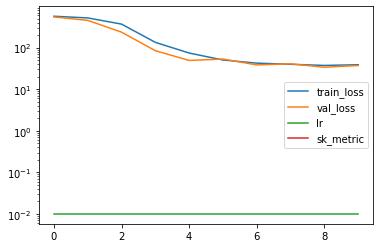

In [5]:
model_params = {'D_in': 63*63+63*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atomic_numbers',9,32,0,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embeds': ['atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'random',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 10,
                'cooldown': 10}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=10)

In [ ]:
ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embed': [('atomic_numbers',6,64,0,True)],
                              'pad': 63, #length of the longest molecule in the dataset
                              'criterion': 'wb97x_dz.energy',
                              'conformation': 'min',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

ani = ANI1x(**ds_params['train_params'])

In [ ]:
ani[1]